In [ ]:
!pip install dash-core-components
!pip install dash
!pip install streamlit

**Import and Preprocessing**

In [ ]:
import pandas as pd 
import matplotlib.pyplot as plt 
import scipy as sp
from scipy import pi 
from scipy import signal
from scipy.fftpack import fft
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import numpy as np
# import dash_core_components as dcc

from scipy import signal
from scipy.fft import fftshift

import streamlit as st

In [ ]:
from sklearn.preprocessing import RobustScaler, MinMaxScaler, StandardScaler, MaxAbsScaler
from sklearn.decomposition import PCA


In [ ]:
plt.rcParams['figure.figsize'] = (10,5)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
cd drive

/content/drive


In [ ]:
cd MyDrive/Major_Project/src/

/content/drive/MyDrive/Major_Project/src


In [ ]:
!pwd

/content/drive/MyDrive/Major_Project/src


In [ ]:
df = pd.read_csv('TUE_feb09.txt', skiprows = 1, sep ='\t')

In [ ]:
df

,address,Time(s),ax(g),ay(g),az(g),AngleX(deg),AngleY(deg),AngleZ(deg),T(°)
0,0x50,16:14:15.651,-0.0068,0.0005,1.0020,-0.0494,0.0714,-0.2747,31.24
1,0x50,16:14:15.651,-0.0083,-0.0068,1.0015,-0.0494,0.0714,-0.2747,31.11
2,0x50,16:14:15.651,0.0054,-0.0088,1.0015,-0.0494,0.0714,-0.2747,31.18
3,0x50,16:14:15.682,0.0068,-0.0063,1.0005,-0.0494,0.0714,-0.2747,30.86
4,0x50,16:14:15.698,0.0078,-0.0044,1.0029,-0.0494,0.0659,-0.2747,31.05
...,...,...,...,...,...,...,...,...,...
64043,0x50,16:35:38.969,-0.0039,-0.0127,1.0015,-0.5658,0.3735,1.3129,33.51
64044,0x50,16:35:39.047,-0.0107,-0.0073,0.9985,-0.5658,0.3735,1.3129,33.51
64045,0x50,16:35:39.047,-0.0078,-0.0161,0.9971,-0.5658,0.3735,1.3129,33.58
64046,0x50,16:35:39.047,-0.0103,-0.0049,0.9980,-0.5658,0.3735,1.3074,33.51


In [ ]:
def addDate(dframe,date_string):

  dframe = date_string + dframe;

  return dframe;


**DataFrame Preprocessing**

In [ ]:
df['Time(s)'] = addDate(df['Time(s)'], '2021-02-09')
df.index = df['Time(s)']
df.index = pd.to_datetime(df.index)
df = df.drop(columns=['address', 'Time(s)'])

2021-03-03 05:34:19.270 INFO    numexpr.utils: NumExpr defaulting to 2 threads.


In [ ]:
az = go.Scatter(x=df.index, y = df['az(g)'], name ="az")
ay = go.Scatter(x=df.index, y = df['ay(g)'], name="ay")
ax = go.Scatter(x=df.index, y = df['ax(g)'], name="ax")
 
figx = make_subplots(rows=3,cols=1)

figx.update_layout(xaxis_title = 'Time', yaxis_title = 'Amplitude(g)')

# figx.add_trace(ax,row=1,col=1)
# figx.add_trace(ay,row=2,col=1)
figx.add_trace(az,row=1,col=1)


figx.show()

**Data Extraction**

In [ ]:
def extract_data(df,start_time,end_time):
  
  extracted_data = df[(df.index >= start_time) & (df.index <= end_time)]
  
  return extracted_data;

In [ ]:
def calc_rms(data,window):

  length = len(data);
  
  n_steps = np.int(np.floor(length/window));

  data_rms = np.zeros((length,1));

  for i in range(0,n_steps):
    data_rms[i] = np.sqrt(np.mean(data[(i * window):((i +1) * window)] ** 2));    

  return data_rms;

**Digital Filtering**

In [ ]:
#@title
def butter_lowpass(data, cutoff,fs, order):
    
    nyq = fs/2;
    
    normal_cutoff = cutoff / nyq #Normalization so that highest frequency = 1
    
    #Filter Coefficients
    
    b,a = signal.butter(order, normal_cutoff, btype='low', analog=False)
    
    y = signal.filtfilt(b,a,data)
    
    return y

In [ ]:
#@title
def butter_highpass(data, cutoff,fs, order):
    
    nyq = fs/2;
    
    normal_cutoff = cutoff / nyq #Normalization so that highest frequency = 1
    
    #Filter Coefficients
    
    b,a = signal.butter(order, normal_cutoff, btype='high', analog=False)
    
    y = signal.filtfilt(b,a,data)
    
    return y

In [ ]:
#@title
#  nl_x_filtered = butter_lowpass(nl_extract,5,20, 5)

# fig = go.Figure()
# fig.add_trace(go.Scatter(
#             y = nl_x_filtered,
#             line =  dict(shape =  'spline' ),
#             name = 'filtered signal'
#             ))
# fig.show()

# plt.plot(nl_x_filtered)

**Fast Fourier Transform and PSD Calculation**

***FFT**

In [ ]:
#@title
def calc_FFT(data,fs):
    
    length = len(data);
    xf = np.linspace(0.0,np.float(fs)/(2.0),np.int(length/2))
    yf = np.fft.fft(data) 
    yf = ((2.0/length) * np.abs(yf[0:np.int(length/2)]))

    return xf, yf;


***PSD**


In [ ]:
#@title
def calc_PSD(data,fs):
  f, psd_y = signal.periodogram(data,fs);
  return f,psd_y;



In [ ]:
def FFT_PSD_calc_plot(data,fs):

  xf, yf = calc_FFT(data,fs);
 
  fig = go.Figure()

  fig.add_trace(go.Scatter(
            x = xf,
            y = yf,
            line =  dict(shape =  'spline' ),
            name = 'Plot',
            mode = 'lines+markers',
            ))
  fig.update_layout(
      
      xaxis_title = "Frequency(Hz)",
      yaxis_title = "Amplitude(g)"
  )

  fig.show()

  #PSD

  f, psd_y = calc_PSD(data,fs);
  
  fig1 = go.Figure()
  
  fig1.add_trace(go.Scatter(
            x = f,
            y = psd_y,
            line =  dict(shape =  'spline' ),
            name = 'Plot',
            mode = 'lines+markers',
            ))

  fig1.update_layout(
      
      xaxis_title = "Frequency(Hz)",
      yaxis_title = "PSD(g^2/Hz)"
    )  
  
  fig1.show()



In [ ]:
def filter_and_plot(data,rolling_window,hpf_cutoff,filter_order,fs):
  # Rolling Mean for Smoothing
  data_roll = data.rolling(rolling_window,1).mean() 
  

  # High Pass Filter To Remove DC Offset
 
  data_filtered = butter_highpass(data_roll,hpf_cutoff,fs,filter_order)
  
  FFT_PSD_calc_plot(data_filtered,fs)

  return data_filtered

In [ ]:
def draw_spectrogram(data,fs,n_per_seg):
   #Spectrogram
  f,t,Sxx = signal.spectrogram(data,fs,nperseg=n_per_seg)
  plt.pcolormesh(t,f,Sxx,shading='gouraud')
  plt.ylabel('Frequency(Hz)')
  plt.xlabel('Time(s)')
  plt.show()


**Case 1: No Moving Vehicles Low Vibrations**

In [ ]:
# nl_extract_y = extract_data(df['ay(g)'],'2021-02-09 16:23:25.000','2021-02-09 16:23:30.000')

# nl_extract_y_filtered = filter_and_plot(nl_extract_y,20,1,5,50)

# draw_spectrogram(nl_extract_y_filtered,50,128)

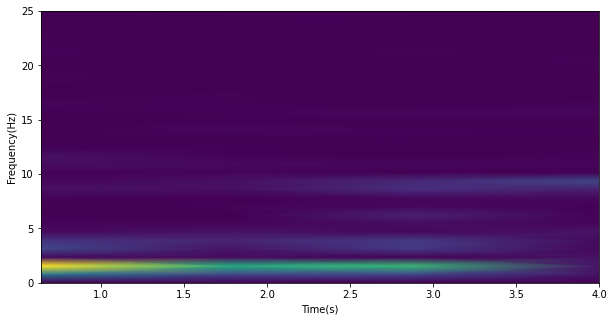

In [ ]:
nl_extract_z = extract_data(df['az(g)'],'2021-02-09 16:23:25.000','2021-02-09 16:23:30.000')

nl_extract_z_filtered = filter_and_plot(nl_extract_z,20,1,5,50)

draw_spectrogram(nl_extract_z_filtered,50,64)


**Case 2: Moving Vehicles - Medium Size Vehicles (Hiace, Sedan, SUVs)**

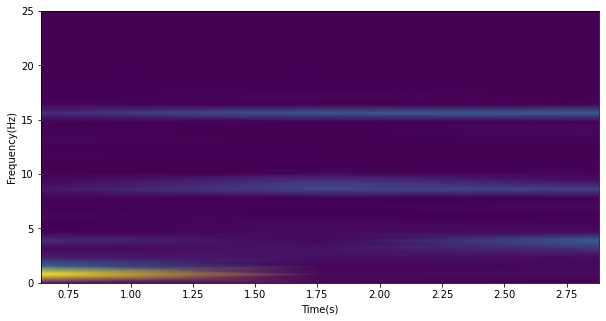

In [ ]:
# medl_extract_y = extract_data(df['ay(g)'],'2021-02-09 16:24:04.000','2021-02-09 16:24:08.000')
medl_extract_z = extract_data(df['az(g)'],'2021-02-09 16:24:04.000','2021-02-09 16:24:08.000')

medl_extract_z_filtered = filter_and_plot(medl_extract_z,20,1,5,50)

draw_spectrogram(medl_extract_z_filtered,50,64)


**Case 3: Moving Vehicles - Large Size Vehicles (Bus)**

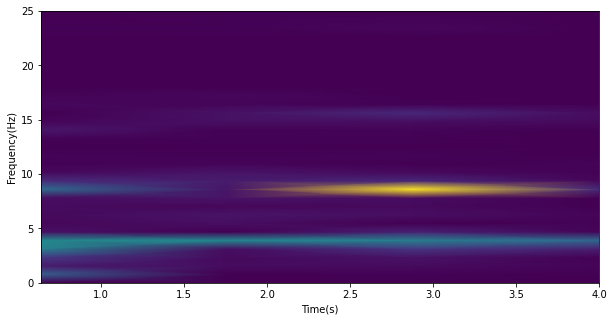

In [ ]:
# highl_extract_y = extract_data(df['ay(g)'],'2021-02-09 16:19:53.000','2021-02-09 16:19:58.000')
highl_extract_z = extract_data(df['az(g)'],'2021-02-09 16:19:53.000','2021-02-09 16:19:58.000')

highl_extract_z_filtered = filter_and_plot(highl_extract_z,20,1,5,50)

draw_spectrogram(highl_extract_z_filtered,50,64)

